In [4]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle
spark = pyspark.sql.SparkSession.builder.getOrCreate()

case_df = spark.read.csv("case.csv", header=True, inferSchema=True)
dept_df = spark.read.csv("dept.csv", header=True, inferSchema=True)
source_df = spark.read.csv("source.csv", header=True, inferSchema=True)

df = wrangle.wrangle_311(case_df, dept_df, source_df)

In [5]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 zipcode              | 78207                
 case_age             | 1316                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS             
only showing top 1 row



#### Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

### How many different cases are there, by department?

In [8]:
# first method get aggregate from spark then graph with pandas

df.groupby('department').count().show(truncate=False)

+------------------------+------+
|department              |count |
+------------------------+------+
|Solid Waste             |286287|
|Animal Care Services    |119362|
|Trans & Cap Improvements|97841 |
|Parks & Recreation      |19964 |
|Customer Service        |2889  |
|Metro Health            |5313  |
|City Council            |34    |
|DSD/Code Enforcement    |323579|
+------------------------+------+



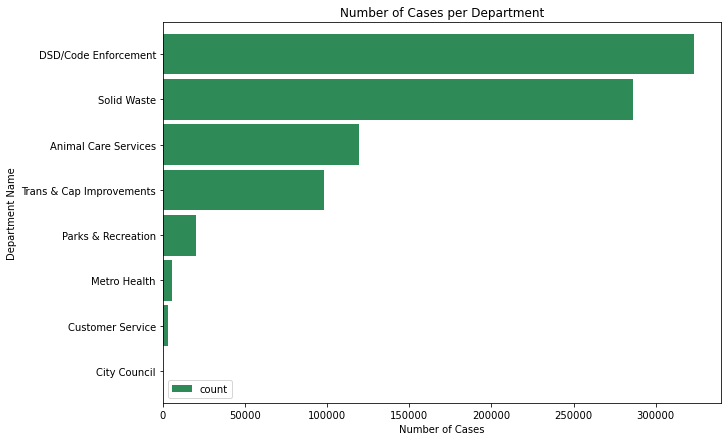

In [9]:
(
    df.groupby('department').count()
    .toPandas()
    .set_index('department')
    .sort_values(by = 'count', ascending = True)
    .plot.barh(color = 'seagreen', figsize = (10,7), width = .9)
)

plt.title('Number of Cases per Department')
plt.xlabel('Number of Cases')
plt.ylabel('Department Name')
plt.show()

### Does the percentage of cases that are late vary by department?

In [10]:
# aggregate in Spark. 
# find percentages of late cases. Stacked Bar Graph

df.groupby('department').pivot('case_late').count().fillna(0).show()

+--------------------+------+-----+
|          department| false| true|
+--------------------+------+-----+
|         Solid Waste|252558|33729|
|Animal Care Services| 95611|23751|
|Trans & Cap Impro...| 92312| 5529|
|    Customer Service|   854| 2035|
|  Parks & Recreation| 16154| 3810|
|        Metro Health|  4459|  854|
|        City Council|    34|    0|
|DSD/Code Enforcement|297140|26439|
+--------------------+------+-----+



In [11]:
late_cases = df.groupby('department').pivot('case_late').count().fillna(0)

In [12]:
late_cases.withColumn('all', ( col('true') + col('false')) ).show()

+--------------------+------+-----+------+
|          department| false| true|   all|
+--------------------+------+-----+------+
|         Solid Waste|252558|33729|286287|
|Animal Care Services| 95611|23751|119362|
|Trans & Cap Impro...| 92312| 5529| 97841|
|    Customer Service|   854| 2035|  2889|
|  Parks & Recreation| 16154| 3810| 19964|
|        Metro Health|  4459|  854|  5313|
|        City Council|    34|    0|    34|
|DSD/Code Enforcement|297140|26439|323579|
+--------------------+------+-----+------+



NameError: name 'mpl' is not defined

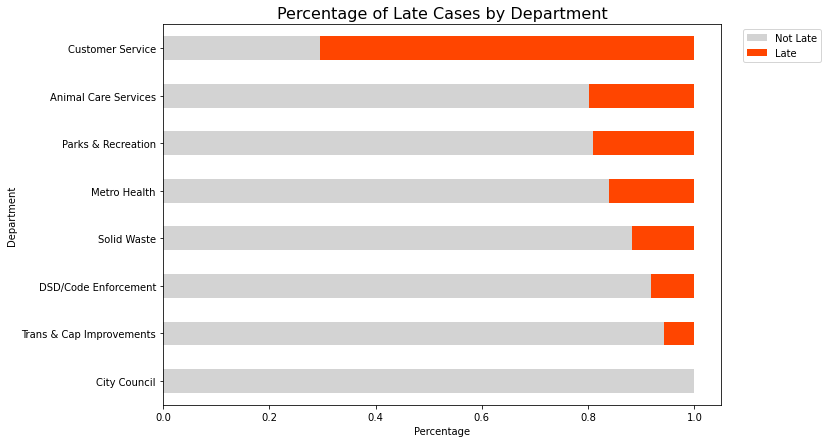

In [13]:
(
    df.groupby('department')
    .pivot('case_late').count()
    .fillna(0)
    .withColumn('all', col('true') + col('false') )
    .toPandas()
    .set_index('department')
    .apply(lambda row: row / row['all'], axis = 1)
    .drop(columns = 'all')
    .sort_values(by = 'true')
    .plot.barh(stacked = True, figsize = (10,7), color = ['lightgrey', 'orangered'])
)

plt.legend(labels = ['Not Late', 'Late'], bbox_to_anchor = ((1.03, 1)))
plt.title('Percentage of Late Cases by Department', fontsize = 16)
plt.xlabel('Percentage')
plt.ylabel('Department')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))

plt.show()

### On average, how late are the late cases by department?

In [14]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show()
)

+--------------------+------------------+
|          department|     avg_days_late|
+--------------------+------------------+
|    Customer Service| 88.18248182589822|
|DSD/Code Enforcement|49.506339986350454|
|Animal Care Services|  23.4467296347382|
|  Parks & Recreation|22.427807192724135|
|Trans & Cap Impro...|10.662950455078674|
|         Solid Waste|7.1471727895574135|
|        Metro Health| 6.494699602827871|
+--------------------+------------------+



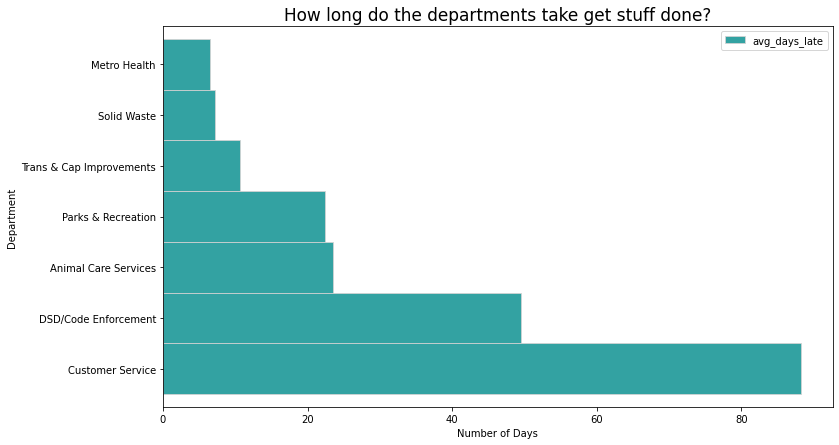

In [15]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('department')
    .plot.barh(width = 1, ec = 'lightgrey', alpha = .8, color = 'darkcyan', figsize = (12,7))
)
plt.title("How long do the departments take get stuff done?", fontsize = 17)
plt.xlabel("Number of Days")
plt.ylabel("Department")
plt.show()

### What is the service type that is the most late? Just for Parks & Rec?

In [16]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509807|
|Donation Containe...|171.09115313942615|
|Storage of Used M...|163.96812829714287|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Traffic Signal Gr...|137.64583330000002|
|License Requied U...|128.79828704142858|
+--------------------+------------------+
only showing top 10 rows



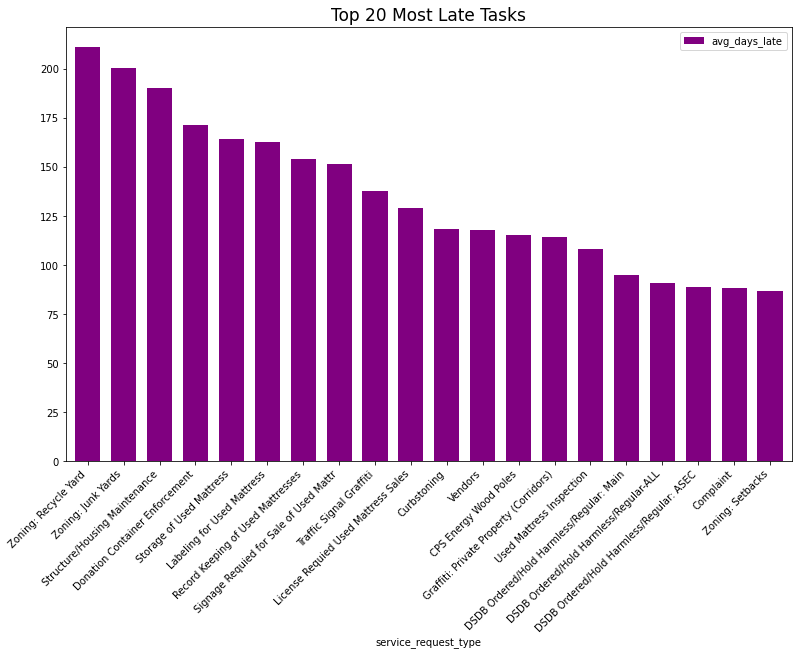

In [17]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(20)
    .plot.bar(figsize = (13,8), width = .7, color = 'purple')
)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Top 20 Most Late Tasks', fontsize = 17)
plt.show()

In [18]:
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Amenity Park Impr...| 76.60603677123078|
|Major Park Improv...| 75.79450367282354|
|Reservation Assis...|       66.03116319|
|Park Building Mai...|59.367469802695666|
| Sportfield Lighting|52.034858419575656|
|          Electrical|42.951971658345116|
|        Tree Removal| 40.28404224560715|
|Landscape Mainten...| 38.86797941326316|
|     Heavy Equipment| 38.56625730831579|
|Miscellaneous Par...| 33.62472491253488|
+--------------------+------------------+
only showing top 10 rows



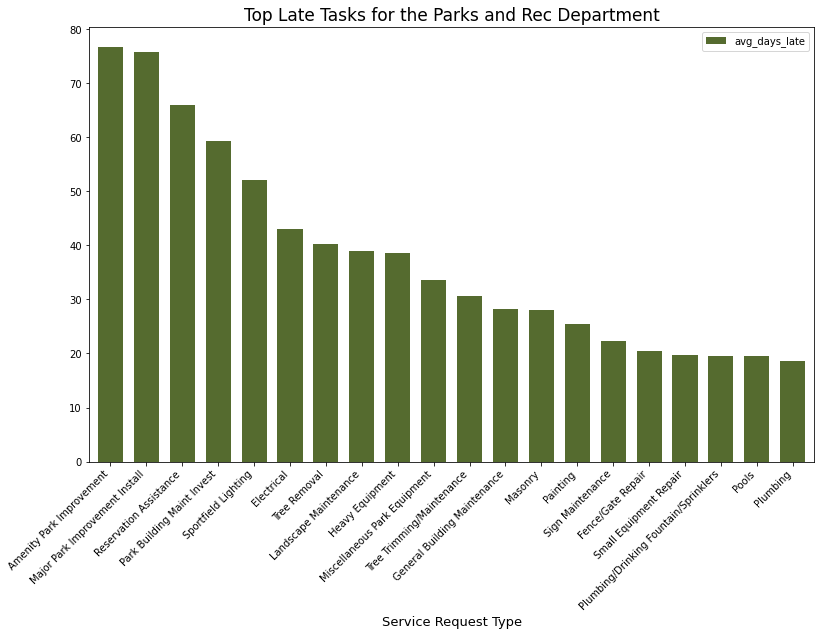

In [19]:
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(20)
    .plot.bar(figsize = (13,8), width = .7, color = 'darkolivegreen')
)
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Service Request Type', fontsize = 13)
plt.title('Top Late Tasks for the Parks and Rec Department', fontsize = 17)
plt.show()

### For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [20]:
(
    df.filter(col('department') == 'DSD/Code Enforcement')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .show(truncate = False)
)

+--------------------------------------+-----+
|service_request_type                  |count|
+--------------------------------------+-----+
|Overgrown Yard/Trash                  |66403|
|Bandit Signs                          |32968|
|Front Or Side Yard Parking            |28920|
|Junk Vehicle On Private Property      |21649|
|Alley-Way Maintenance                 |20293|
|Right Of Way/Sidewalk Obstruction     |17836|
|Vacant Lot/Overgrown/Trash            |9497 |
|Minimum Housing-Owner Occupied        |8617 |
|Graffiti: Private Property (Corridors)|8525 |
|Minimum Housing-Tenant Occupied       |8104 |
|Dang. Premises/CL/SEC                 |8004 |
|"Vacant Lot-Private (12"")"           |7875 |
|Brush Violations                      |7530 |
|Permits Building                      |6950 |
|Vacant House Overgrown Yard           |6278 |
|Graffiti: Building                    |4572 |
|Low Hanging Limbs on Streets/Sidewalk |4107 |
|Graffiti Public Property              |4104 |
|CPS Energy W

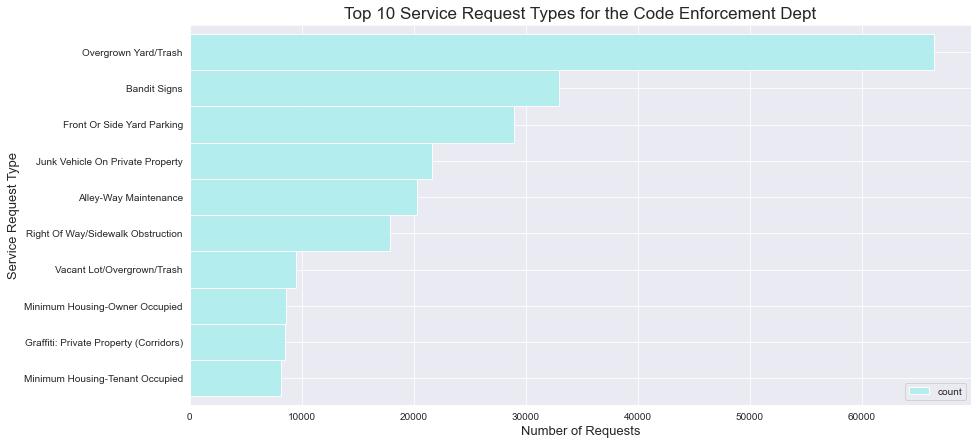

In [21]:
with sns.axes_style('darkgrid'):
    
    (
        df.filter(col('department') == 'DSD/Code Enforcement')
        .groupby('service_request_type').count()
        .sort(desc('count'))
        .toPandas()
        .set_index('service_request_type')
        .head(10)
        .sort_values(by = 'count', ascending = True)
        .plot.barh(figsize = (14,7), color = 'paleturquoise', width = 1, ec = 'white', alpha = .9)
    )
    plt.title('Top 10 Service Request Types for the Code Enforcement Dept', fontsize = 17)
    plt.xlabel('Number of Requests', fontsize = 13)
    plt.ylabel('Service Request Type', fontsize = 13)
    plt.show()

### Does whether or not its a weekend matter for when a case is opened/closed?

### On average, how many cases are opened a day for the Customer Service department?

### Does the number of service requests for the solid waste department vary by day of the week?